Project: 3

Student: Melisa Bardhi

Instructor: Jeff Herman

Blog: https://melisabardhi.github.io/no_free_lunch_logistic_regression_vs_random_forest

Date: 12/02/2020


In [1]:
# Import libraries and packages

import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns', 70)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns
import seaborn as sns; sns.set_context('talk')
sns.set(rc = {'figure.figsize' : (11, 4)})

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score

from scipy.stats import randint

from pickle import dump

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import random

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Data Cleaning


Below we will clean the data to perform exploratory analysis.

In [2]:
# Read csv file and preview data
df = pd.read_csv('Terry_Stops.csv')

In [3]:
df.head(3)

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,-,-,2015-03-19T00:00:00,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,White,Male,2015-03-21T00:00:00,19:12:00,-,-,-,NaN,N,-,-,-,-


In [4]:
# Rename columns 
df = df.rename(columns={'Subject Age Group': 'subj_age_group', 
                                        'Subject ID': 'subj_id', 
                                        'GO / SC Num': 'go_sc_num', 
                                        'Terry Stop ID': 'terry_stop_id', 
                                        'Stop Resolution': 'stop_resolution', 
                                        'Weapon Type': 'weapon',
                                        'Officer ID': 'off_id',
                                        'Officer YOB': 'off_yob',
                                        'Officer Gender': 'off_gender',
                                        'Officer Race':'off_race',
                                        'Subject Perceived Race':'subj_perceived_race',
                                        'Subject Perceived Gender':'subj_perceived_gender',
                                        'Reported Date':'reported_date',
                                        'Reported Time':'reported_time',
                                        'Initial Call Type':'init_call_type',
                                        'Final Call Type':'final_call_type',
                                        'Call Type':'call_type',
                                        'Officer Squad':'off_squad',
                                        'Arrest Flag':'arrest_flag',
                                        'Frisk Flag': 'frisk_flag',
                                        'Precinct':'precinct',
                                        'Sector':'sector',
                                        'Beat':'beat'})

In [5]:
# Convert '-' to NA
df = df.replace('-', 'N/A')

# '-1'in Subject ID to N/A
df.subj_id = df.subj_id.replace(-1, 'N/A')

# 'Officer Squad' to general precint/squad
df.off_squad = df.off_squad.replace(to_replace=' -.*', value='', regex=True)

# 'N' in Gender to N/A
df.off_gender = df.off_gender.replace('N', 'N/A')

##### Time

In [6]:
### Remove "T" character in timestamp to access time
df['reported_date'] = df['reported_date'].str.replace('T', ' ')

# Convert series to datetime
df['reported_date'] = pd.to_datetime(df['reported_date'])

# Create columns for comments' year, month, day, and hour
df['reported_year'] = pd.DatetimeIndex(df['reported_date']).year
df['reported_month'] = pd.DatetimeIndex(df['reported_date']).month
df['reported_day'] = pd.DatetimeIndex(df['reported_date']).day
df['reported_hour'] = [x[:2] for x in df['reported_time']]

# Subtract officer year of birth from the reported year
df['off_age'] = df['reported_year'] - df['off_yob']

In [7]:
# Trim whitespace
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

##### Weapons

In [8]:
# Categorize
df = df.replace(to_replace='-', value='None')
df = df.replace(to_replace='Lethal Cutting Instrument', value='Blade')
df = df.replace(to_replace='Firearm Other', value='Firearm')
df = df.replace(to_replace='Handgun', value='Firearm')
df = df.replace(to_replace='Club, Blackjack, Brass Knuckles', value='Blunt Object')
df = df.replace(to_replace='Knife/Cutting/Stabbing Instrument', value='Blade')
df = df.replace(to_replace='Rifle', value='Firearm')
df = df.replace(to_replace='Fire/Incendiary Device', value='Non-Lethal')
df = df.replace(to_replace='Firearm (unk type)', value='Firearm')
df = df.replace(to_replace='Other Firearm', value='Firearm')
df = df.replace(to_replace='Club', value='Blunt Object')
df = df.replace(to_replace='Mace/Pepper Spray', value='Non-Lethal')
df = df.replace(to_replace='Blunt Object/Striking Implement', value='Blunt Object')
df = df.replace(to_replace='Firearm', value='Firearm')
df = df.replace(to_replace='Brass Knuckles', value='Blunt Object')
df = df.replace(to_replace='Automatic Handgun', value='Firearm')
df = df.replace(to_replace='Taser/Stun Gun', value='Non-Lethal')
df = df.replace(to_replace='None/Not Applicable', value='None')
df = df.replace(to_replace='Blackjack', value='Blunt Object')
df = df.replace(to_replace='Shotgun', value='Firearm')

##### Officer Race

In [9]:
df.off_race.unique()

array(['Black or African American', 'White', 'Hispanic or Latino',
       'Asian', 'American Indian/Alaska Native', 'Two or More Races',
       'Nat Hawaiian/Oth Pac Islander', 'Not Specified', 'Unknown'],
      dtype=object)

In [10]:
# Change officer race from "Unknown" and "Not Specified" to "N/A"
df.off_race = df.off_race.replace('Unknown', 'N/A')
df.off_race = df.off_race.replace('Not Specified', 'N/A')

In [11]:
df.off_race.unique()

array(['Black or African American', 'White', 'Hispanic or Latino',
       'Asian', 'American Indian/Alaska Native', 'Two or More Races',
       'Nat Hawaiian/Oth Pac Islander', 'N/A'], dtype=object)

In [12]:
# Officer race categories include not specified and unknown
df.off_race.value_counts(ascending = False)

White                            33117
Hispanic or Latino                2371
Two or More Races                 2283
Black or African American         1713
Asian                             1666
N/A                                979
Nat Hawaiian/Oth Pac Islander      428
American Indian/Alaska Native      310
Name: off_race, dtype: int64

##### Subject Race

In [13]:
df.subj_perceived_race.unique()

array(['Asian', 'N/A', 'White', 'Black or African American', 'Other',
       'Unknown', 'American Indian or Alaska Native', 'Hispanic',
       'Multi-Racial', 'Native Hawaiian or Other Pacific Islander'],
      dtype=object)

In [14]:
# Change subject's perceived race from "Unknown" and "Other" to "N/A"
df.subj_perceived_race = df.subj_perceived_race.replace('Unknown', 'N/A')
df.subj_perceived_race = df.subj_perceived_race.replace('Other', 'N/A')

In [15]:
df.subj_perceived_race.unique()


array(['Asian', 'N/A', 'White', 'Black or African American',
       'American Indian or Alaska Native', 'Hispanic', 'Multi-Racial',
       'Native Hawaiian or Other Pacific Islander'], dtype=object)

In [16]:
# Check for nulls
len(df[pd.isnull(df.subj_perceived_race)])

0

##### Subject Gender

In [17]:
df.subj_perceived_gender.unique()

array(['Male', 'N/A', 'Female', 'Unable to Determine', 'Unknown',
       'Gender Diverse (gender non-conforming and/or transgender)'],
      dtype=object)

In [18]:
df.subj_perceived_gender = df.subj_perceived_gender.replace(['Unable to Determine', 'Unknown', 'Gender Diverse (gender non-conforming and/or transgender)'], 'N/A')

In [19]:
df.subj_perceived_gender.unique()

array(['Male', 'N/A', 'Female'], dtype=object)

In [20]:

df = df.drop(df[pd.isnull(df.subj_perceived_race)].index)

##### Beat

In police terminology, a beat is the territory and time that a police officer patrols.

In [21]:
# Combine beats to account for general geographical area:
df['beat_type'] = df.beat
df['beat'] = df.beat.replace(to_replace=['B1','B2','B3'], value='B')
df['beat'] = df.beat.replace(to_replace=['C1','C2','C3'], value='C')
df['beat'] = df.beat.replace(to_replace=['D1','D2','D3'], value='D')
df['beat'] = df.beat.replace(to_replace=['E1','E2','E3'], value='E')
df['beat'] = df.beat.replace(to_replace=['F1','F2','F3'], value='F')
df['beat'] = df.beat.replace(to_replace=['G1','G2','G3'], value='G')
df['beat'] = df.beat.replace(to_replace=['J1','J2','J3'], value='J')
df['beat'] = df.beat.replace(to_replace=['K1','K2','K3'], value='K')
df['beat'] = df.beat.replace(to_replace=['L1','L2','L3'], value='L')
df['beat'] = df.beat.replace(to_replace=['M1','M2','M3'], value='M')
df['beat'] = df.beat.replace(to_replace=['N1','N2','N3'], value='N')
df['beat'] = df.beat.replace(to_replace=['O1','O2','O3'], value='O')
df['beat'] = df.beat.replace(to_replace=['Q1','Q2','Q3'], value='Q')
df['beat'] = df.beat.replace(to_replace=['R1','R2','R3'], value='R')
df['beat'] = df.beat.replace(to_replace=['S1','S2','S3'], value='S')
df['beat'] = df.beat.replace(to_replace=['U1','U2','U3'], value='U')
df['beat'] = df.beat.replace(to_replace=['W1','W2','W3'], value='W')

In [22]:
df.beat_type.isna().sum()

0

##### Officer Age

In [23]:
# Drop the rows with officers aged over 70 years
df = df.drop(df[df.off_age > 70].index)

##### Call Type

In [24]:
# Check call types
df.call_type.unique()

array(['N/A', '911', 'ONVIEW', 'TELEPHONE OTHER, NOT 911',
       'ALARM CALL (NOT POLICE ALARM)', 'PROACTIVE (OFFICER INITIATED)',
       'SCHEDULED EVENT (RECURRING)', 'TEXT MESSAGE'], dtype=object)

In [25]:
# View N/As for call_type
print(df.init_call_type.nunique())
print(df.call_type.value_counts(dropna = False))

161
911                              18713
N/A                              12796
ONVIEW                            8113
TELEPHONE OTHER, NOT 911          2965
ALARM CALL (NOT POLICE ALARM)      261
PROACTIVE (OFFICER INITIATED)        2
TEXT MESSAGE                         2
SCHEDULED EVENT (RECURRING)          1
Name: call_type, dtype: int64


##### Frisk and Arrest Flags

In [26]:
# Check count of frisk categories
df.frisk_flag.value_counts(dropna = False)

N      32966
Y       9409
N/A      478
Name: frisk_flag, dtype: int64

In [27]:
# Check count of frisk categories
df.arrest_flag.value_counts(dropna = False)

N    40732
Y     2121
Name: arrest_flag, dtype: int64

In [28]:
# Dictionary to replace string with boolean
clean_flags = {'frisk_flag' : {'Y' : 1, 'N' : 0}, 
              'arrest_flag' : {'Y' : 1, 'N' : 0}}

# Replace
df.replace(clean_flags, inplace = True)

##### Convert to categorical

In [29]:
# Change the data type for the category & datetime columns
df = df.astype({'subj_age_group': 'category', 
                'off_gender':'category', 
                'off_race': 'category', 
                'subj_perceived_race':'category', 
                'subj_perceived_gender':'category',
                'arrest_flag':'category', 
                'frisk_flag':'category',
                'precinct':'category', 
                'sector':'category',
                'beat': 'category'})

In [30]:
# create the path for the new file
df.to_csv('Terry_Stops_Clean.csv', index=False)

# Exploratory Data Analysis

### Stop resolution types

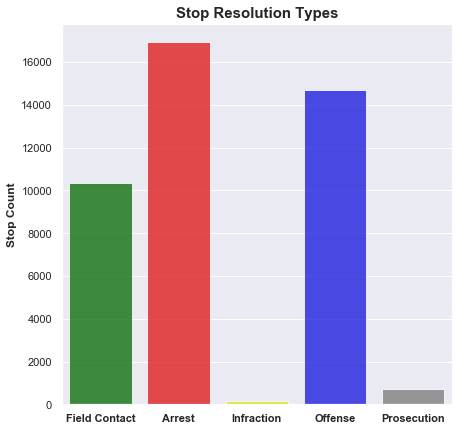

In [31]:
sns.set_style('darkgrid')
plt.figure(figsize = (7,7))
sns.countplot(df.stop_resolution, alpha =.80, palette=['green','red','yellow','blue','gray'])
plt.title('Stop Resolution Types', fontdict={'fontweight':'bold', 'fontsize':15})
plt.xticks(ticks=[0,1,2,3,4], labels=['Field Contact','Arrest', 'Infraction', 'Offense', 'Prosecution'], weight='bold')
plt.ylabel('Stop Count', weight='bold')
plt.xlabel('')
plt.show()

### Stop resolutions by year

In [32]:
# Sum of stop resolutions for each year
year = df.groupby(['reported_year','stop_resolution']).stop_resolution.count()
arrest = [year[0], year[5], year[10], year[15], year[20], year[25]]
no_arrest = [year[1:5].sum(), year[6:10].sum(), year[11:15].sum(), year[16:20].sum(), year[21:25].sum(), year[25:].sum()]
years = ['2015', '2016', '2017', '2018', '2019', '2020']

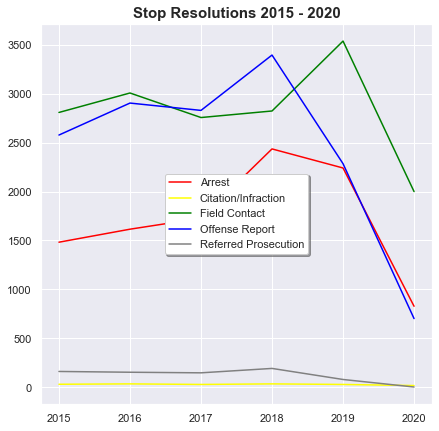

In [33]:
# Distinguish by resolution type
citation_infraction = [year[1], year[6], year[11], year[16], year[21], year[26]]
field_contact = [year[2], year[7], year[12], year[17], year[22], year[27]]
offense_report = [year[3], year[8], year[13], year[18], year[23], year[28]]
referred_prosecution = [year[4], year[9], year[14], year[19], year[24], year[29]]
legend_stop_res = ['Arrest', 'Citation/Infraction', 'Field Contact', 'Offense Report', 'Referred Prosecution']

plt.figure(figsize=(7,7))
l1 = plt.plot(years, arrest, color='red')
l2 = plt.plot(years, citation_infraction, color='yellow')
l3 = plt.plot(years, field_contact, color='green')
l4 = plt.plot(years, offense_report, color='blue')
l5 = plt.plot(years, referred_prosecution, color='gray')
plt.title('Stop Resolutions 2015 - 2020', fontweight='bold', fontsize=15)
plt.legend(legend_stop_res, shadow=True, facecolor='white')
plt.show()


### Terry stops over time

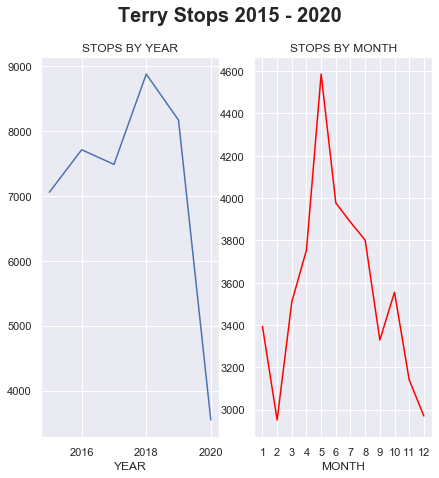

In [34]:
# Terry Stops aggregated by year and month 
stops_year = df.reported_year.value_counts().sort_index()
stops_month = df.reported_month.value_counts().sort_index()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(7,7))
plt.suptitle('Terry Stops 2015 - 2020', fontweight='bold', fontsize=20)
ax1.plot(stops_year)
ax1.title.set_text('STOPS BY YEAR')
ax1.set_xlabel('YEAR')
ax2.plot(stops_month, color='red')
ax2.title.set_text('STOPS BY MONTH')
ax2.set_xlabel('MONTH')
plt.xticks(range(1,13))
plt.show()


In [35]:
# Convert data type
df = pd.read_csv('Terry_Stops_Clean.csv', parse_dates = ['reported_date'], index_col = 'reported_date')

In [36]:
# Count each non-NA item 
df.sort_index(inplace = True)
df['count'] = 1

In [37]:
# Filter dates for dataframe
df2 = df.copy()
df2 = df.loc['2015-04':'2019-04']

# Resample for a monthly frequency and plot the number of stops
df2 = df2['count'].resample('M').count()

Text(0, 0.5, 'Number of Stops')

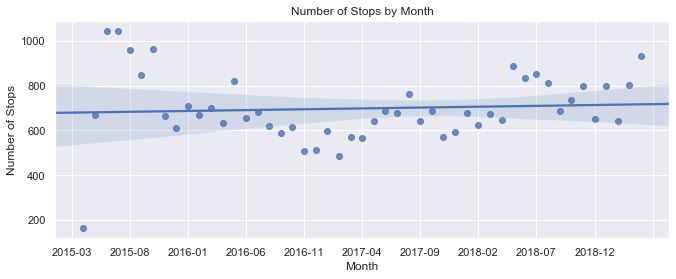

In [38]:
# Designate axes
y = df2.values
x = np.linspace(1, len(y), num = len(y))

# Plot data and a linear regression model fit
plt.figure(figsize=(11, 4))
ax = plt.subplot(1,1,1)
p = sns.regplot(x , y)

# Format axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
dates = pd.date_range(start= '2014-10-31', end = df2.index[-1], freq = '5M')
dates = [d.strftime('%Y-%m') for d in dates]
ax = ax.set_xticklabels(dates)

plt.title('Number of Stops by Month')
plt.xlabel('Month')
plt.ylabel('Number of Stops')

### Call types

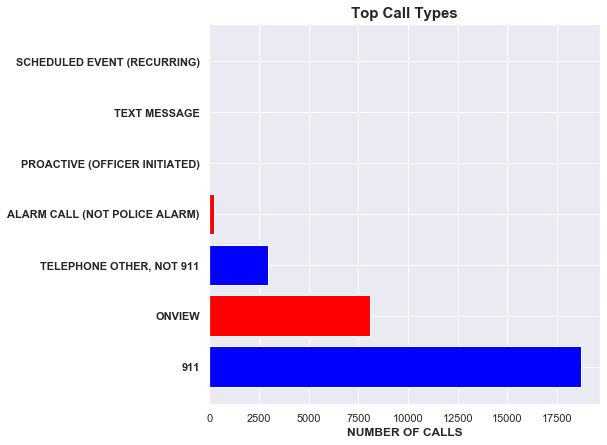

In [39]:
# View top calltypes
plt.figure(figsize=(7,7))
plt.barh(df.call_type.value_counts().index, df.call_type.value_counts().values, color=['blue', 'red'])
plt.yticks(fontweight='bold')
plt.title('Top Call Types', fontweight='bold', fontsize=15)
plt.xlabel('NUMBER OF CALLS', fontweight='bold')
plt.show()

### Arrests in each beat

In [40]:
# Beat summary 
print('{} {}'.format('Beats N/A:', df.beat_type.isna().sum()))
print('{} {}'.format('Total Beats Values:', len(df.beat_type)))
print('{} {}'.format('% Missing:', df.beat_type.isna().sum()/len(df.beat_type)))

Beats N/A: 9761
Total Beats Values: 42853
% Missing: 0.2277786852729097


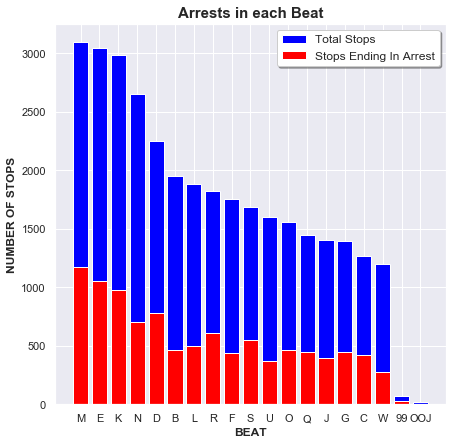

In [41]:
# Beats aggregated
beat_total = df.beat.value_counts()
beat_arrest = df[df.stop_resolution == 'Arrest'].beat.value_counts()

plt.figure(figsize=(7,7))
plot_1 = plt.bar(beat_total.index, beat_total.values, color='blue')
plot_2 = plt.bar(beat_arrest.index, beat_arrest.values, color='red')
plt.xlabel('BEAT', fontweight='bold')
plt.ylabel('NUMBER OF STOPS', fontweight='bold')
plt.title('Arrests in each Beat', fontweight='bold', fontsize=15)
plt.legend(['Total Stops','Stops Ending In Arrest'], fontsize='large', shadow=True, facecolor='white')
plt.show()

### Arrests relative to stops by officer age

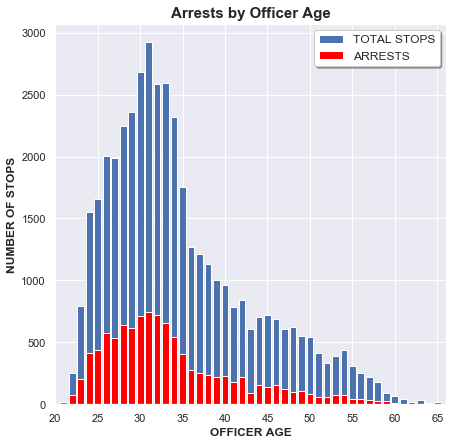

In [42]:
# Arrests relative to total stops
off_age_arrests = df[df.stop_resolution == 'Arrest'].off_age.value_counts()
off_age_total = df.off_age.value_counts()

plt.figure(figsize=(7,7))
plt.title('Arrests by Officer Age', fontweight='bold', fontsize=15)
plt.bar(off_age_total.index, off_age_total.values)
plt.bar(off_age_arrests.index, off_age_arrests.values, color='red')
plt.legend(['TOTAL STOPS', 'ARRESTS'], facecolor='white', shadow=True, fontsize='large')
plt.xticks(range(20,67,5))
plt.xlabel('OFFICER AGE', fontweight='bold')
plt.ylabel('NUMBER OF STOPS', fontweight='bold')
plt.xlim(20,66)
plt.show()

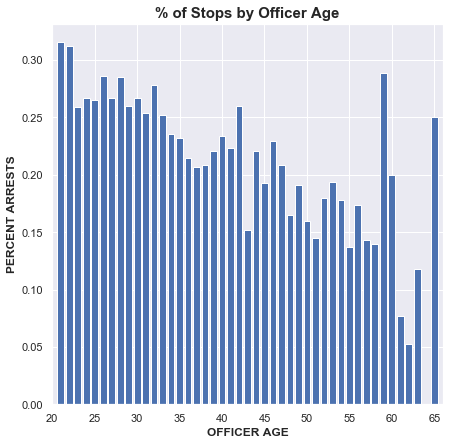

In [43]:
# % Of arrests per officer age
plt.figure(figsize=(7,7))
plt.title('% of Stops by Officer Age', fontweight='bold', fontsize=15)
pct_off_age_arrests = off_age_arrests/off_age_total
plt.bar(pct_off_age_arrests.index, pct_off_age_arrests.values)
plt.ylabel('PERCENT ARRESTS', fontweight='bold')
plt.xlabel('OFFICER AGE', fontweight='bold')
plt.xticks(range(20,67,5))
plt.xlim(20,66)
plt.show()

### Stops by officer race

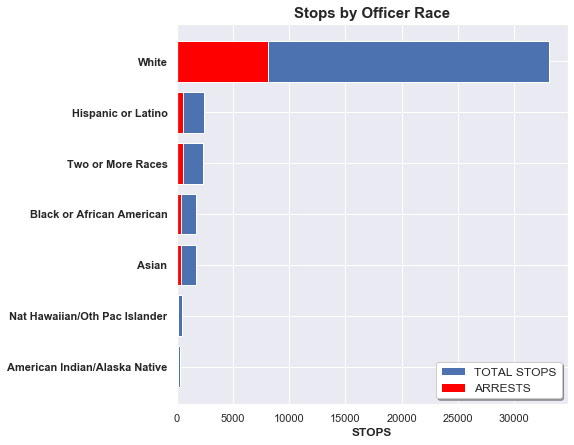

In [44]:
# Stops by officer race
off_race_total = df.off_race.value_counts().sort_values(ascending=True)
off_race_arrest = df[df.stop_resolution == 'Arrest'].off_race.value_counts()
plt.figure(figsize=(7,7))
plt.title('Stops by Officer Race', fontweight='bold', fontsize=15)
plt.barh(off_race_total.index, off_race_total.values)
plt.barh(off_race_arrest.index, off_race_arrest.values, color = 'red')
plt.yticks(fontweight='bold')
plt.xlabel('STOPS', fontweight='bold')
plt.legend(['TOTAL STOPS', 'ARRESTS'], loc='lower right', shadow=True, fontsize='large', facecolor='white')
plt.show()

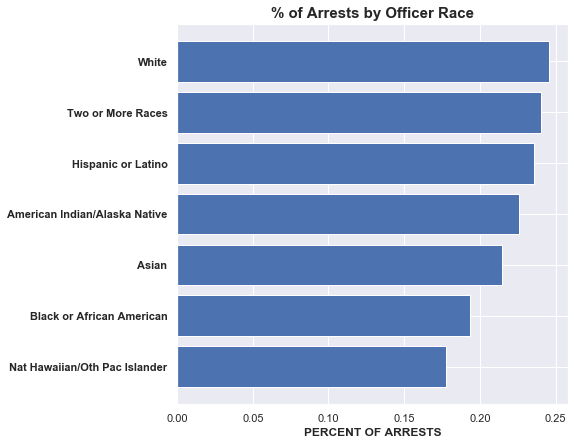

In [45]:
# Arrests by officer race
off_race_arrest = df[df.stop_resolution == 'Arrest'].off_race.value_counts()
off_race_total = df.off_race.value_counts()
off_race_arrest_pct = (off_race_arrest/off_race_total).sort_values(ascending=True)

plt.figure(figsize=(7,7))
plt.title('% of Arrests by Officer Race', fontsize=15, fontweight='bold')
plt.barh(off_race_arrest_pct.index, off_race_arrest_pct.values)
plt.xlabel('PERCENT OF ARRESTS', fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

### Seattle census demographics

In [46]:
# Census population
stops_subj_race = df.subj_perceived_race.value_counts().sort_values(ascending=True)
subj_labels = ['Multi-Racial', 'White', 'Hispanic', 'Native Hawaiian or Other Pacific Islander',
               'Black or African American', 'Asian','American Indian or Alaska Native']
seattle_pop = [.068,.680,.066,.003,.070,.150,.006]
pct_stops_subj_race = stops_subj_race/stops_subj_race.sum()

print('{}\n{}\n{}'.format('Missing Values', 42566 - stops_subj_race.sum(), '---'*15))
print('{}\n{}'.format('Census Population', '---'*15))
for l, p in zip(subj_labels, seattle_pop):
    print(l + ':', p)

Missing Values
3672
---------------------------------------------
Census Population
---------------------------------------------
Multi-Racial: 0.068
White: 0.68
Hispanic: 0.066
Native Hawaiian or Other Pacific Islander: 0.003
Black or African American: 0.07
Asian: 0.15
American Indian or Alaska Native: 0.006


Data Source for Census Information: https://www.census.gov/quickfacts/fact/table/seattlecitywashington,US/PST045219

In [47]:
# Count non-NA cells
df.sort_index(inplace = True)
df['count'] = 1

In [48]:
# Get % of stops for each subject race
df2 = df[['subj_perceived_race','count']]
df2 = df2.groupby('subj_perceived_race').count()
df2['stop_pct'] = df2['count'] / df2['count'].sum()
df2.drop(['count'], axis = 1, inplace = True)

In [49]:
df2.head(10)

,stop_pct
subj_perceived_race,
American Indian or Alaska Native,0.032447
Asian,0.034555
Black or African American,0.327994
Hispanic,0.043271
Multi-Racial,0.020800
Native Hawaiian or Other Pacific Islander,0.000874
White,0.540058


In [50]:
# Dataframe with census data information & join with main information
census_data = pd.DataFrame(index = df2.index, data = {'census_pct' : [.006,.150,.070,.066,.068,.003,.680,]} )
df2 = df2.join(census_data)
df2 = df2[df2.index != 'Unknown']

In [51]:
df2.head(10)

,stop_pct,census_pct
subj_perceived_race,,
American Indian or Alaska Native,0.032447,0.006
Asian,0.034555,0.150
Black or African American,0.327994,0.070
Hispanic,0.043271,0.066
Multi-Racial,0.020800,0.068
Native Hawaiian or Other Pacific Islander,0.000874,0.003
White,0.540058,0.680


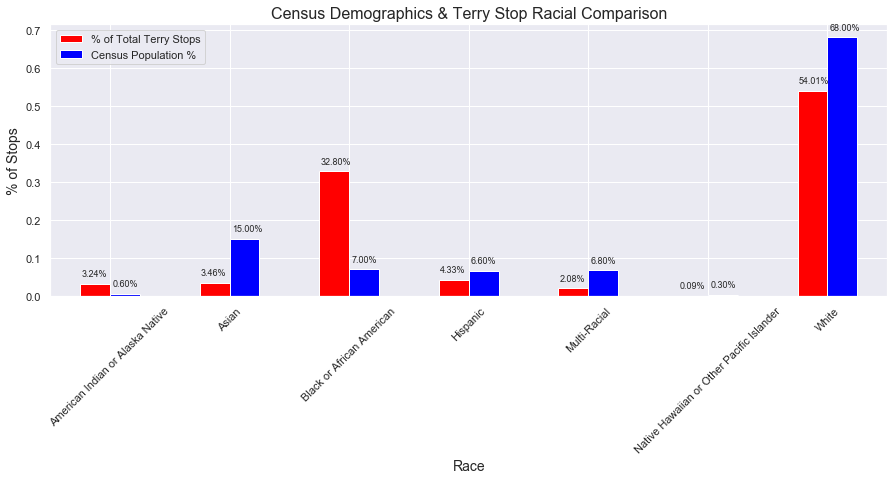

In [52]:
# Plots to compare difference between arrests and census
ax = df2.plot(kind = 'bar', figsize = (15,5), color = ['red','blue'])

# Bar Graph
for i, v in enumerate(df2.stop_pct):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )
    
for i, v in enumerate(df2.census_pct):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9)

plt.xticks(rotation = 45)
plt.title('Census Demographics & Terry Stop Racial Comparison', fontsize = 16)
plt.xlabel('Race', fontsize = 14)
plt.ylabel('% of Stops', fontsize = 14)
plt.legend(loc = 'best', labels = ['% of Total Terry Stops', 'Census Population %'] )
plt.show()


### Stops by subject race

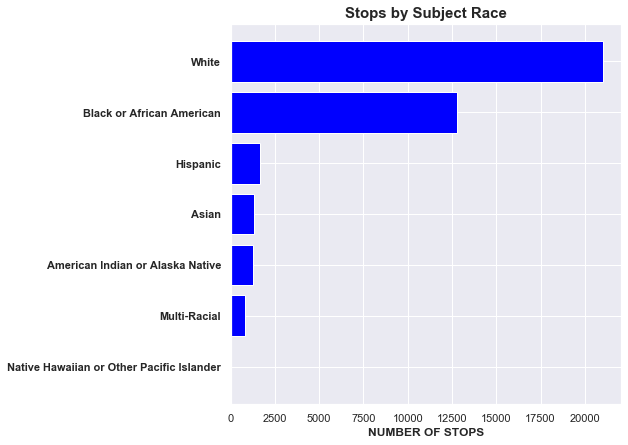

In [53]:
# Stops by subject race
plt.figure(figsize=(7,7))
plt.title('Stops by Subject Race', fontweight='bold', fontsize=15)
plt.barh(stops_subj_race.index, stops_subj_race.values, color = 'blue')
plt.yticks(fontweight='bold')
plt.xlabel('NUMBER OF STOPS', fontweight='bold')
plt.show()

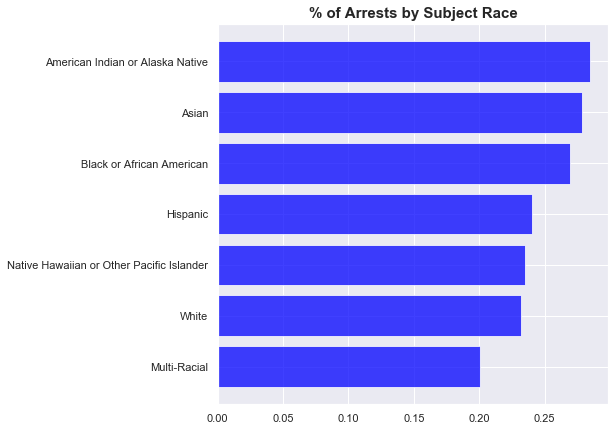

In [54]:
# Arrests by subject race
arrest_subj_race = df[df.stop_resolution == 'Arrest'].subj_perceived_race.value_counts().sort_values(ascending=False)
pct_arrest_subj_race = (arrest_subj_race/stops_subj_race).sort_values()

plt.figure(figsize=(7,7))
plt.barh(pct_arrest_subj_race.index, pct_arrest_subj_race.values, alpha=0.75, color='blue')
plt.title('% of Arrests by Subject Race', fontweight='bold', fontsize=15)
plt.show()

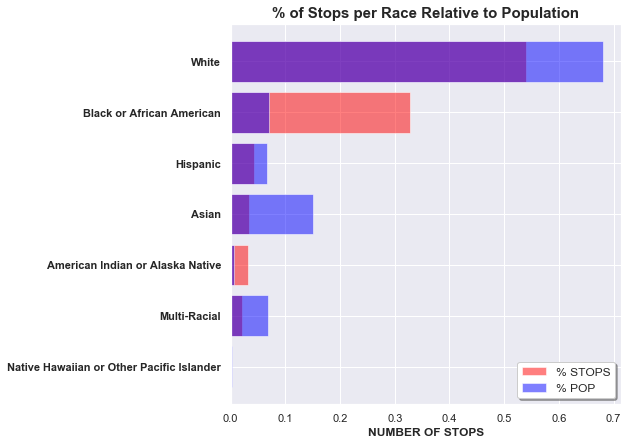

In [55]:
# Relative to population
plt.figure(figsize=(7,7))
plt.title('% of Stops per Race Relative to Population', fontweight='bold', fontsize=15)
plt.barh(pct_stops_subj_race.index, pct_stops_subj_race.values, alpha=0.5, color='red')
plt.barh(subj_labels, seattle_pop, alpha=0.5, color='blue')
plt.yticks(fontweight='bold')
plt.xlabel('NUMBER OF STOPS', fontweight='bold')
plt.legend(['% STOPS', '% POP'], loc='lower right', shadow=True, facecolor='white', fontsize='large')
plt.show()

### Seattle police department

In [56]:
# Subset the data
df3 = df[['off_race','count']]
df3 = df3.groupby('off_race')[['count']].count()
df3.head()

,count
off_race,
American Indian/Alaska Native,310
Asian,1666
Black or African American,1713
Hispanic or Latino,2371
Nat Hawaiian/Oth Pac Islander,428


In [57]:
# Create dataframe with demographics of the Seattle Police Force
police_race = pd.DataFrame(index = ['White', 'Hispanic or Latino', 'Black or African American', 'Asian'], 
                           data = {'seattle_police' : [.753,.052,.086,.086]} )

# Generate percentage of each officer race in data set
df3['officer_race_percent'] = df3['count'] / int(df3.sum())

# Drop original columns
df3.drop(['count'], inplace = True, axis = 1)

# Join both dataframes, with % of Terry Stop police race % of overall Seattle police force race
df3 = df3.join(police_race)
df3.head()

,officer_race_percent,seattle_police
off_race,,
American Indian/Alaska Native,0.007401,NaN
Asian,0.039773,0.086
Black or African American,0.040895,0.086
Hispanic or Latino,0.056603,0.052
Nat Hawaiian/Oth Pac Islander,0.010218,NaN


In [58]:
# Generate text values above the columns
for i, v in enumerate(df3.officer_race_percent):
    ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
for i, v in enumerate(df3.seattle_police):
    ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
    
# Table
df3.head()

,officer_race_percent,seattle_police
off_race,,
American Indian/Alaska Native,0.007401,NaN
Asian,0.039773,0.086
Black or African American,0.040895,0.086
Hispanic or Latino,0.056603,0.052
Nat Hawaiian/Oth Pac Islander,0.010218,NaN


Source of police force race data: https://www.governing.com/gov-data/safety-justice/police-department-officer-demographics-minority-representation.html

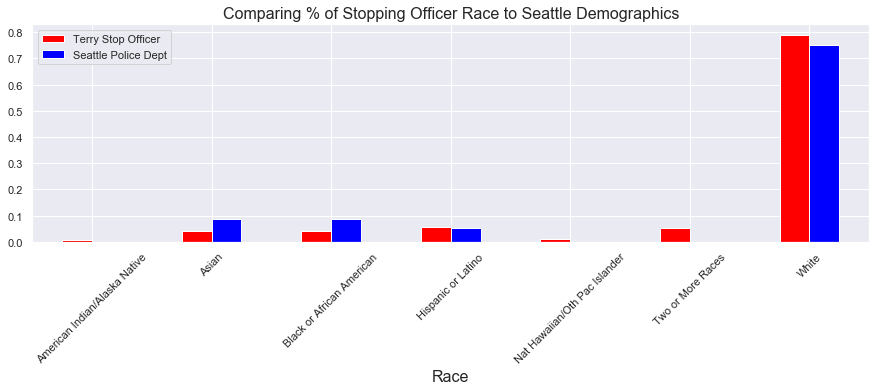

In [59]:
# Display barplot
df3.plot(kind = 'bar', figsize = (15, 4), color = ['red', 'blue'])
plt.xticks(rotation = 45)
plt.title('Comparing % of Stopping Officer Race to Seattle Demographics', fontsize = 16)
plt.xlabel('Race', fontsize = 16)
plt.legend(loc = 'best', labels = ['Terry Stop Officer', 'Seattle Police Dept'])

### Frisks by subject race

In [60]:
# Subset the data
df4 = df[['subj_perceived_race', 'arrest_flag', 'frisk_flag','count']]
df4 = df4.groupby('subj_perceived_race')['arrest_flag','frisk_flag','count'].sum()

# Generate two new columns with % of frisks & arrests
df4['percent_arrest'] = df4.apply(lambda x : x['arrest_flag'] / x['count'], axis = 1 )
df4['percent_frisk']  = df4.apply(lambda x : x['frisk_flag'] / x['count'], axis = 1 )

print(df4.head())
# Drop the original columns
df4.drop(['arrest_flag', 'frisk_flag', 'count'], axis = 1, inplace = True)   


                                  arrest_flag  frisk_flag  count  \
subj_perceived_race                                                
American Indian or Alaska Native           56       281.0   1262   
Asian                                      89       348.0   1344   
Black or African American                 701      3334.0  12757   
Hispanic                                    0       435.0   1683   
Multi-Racial                                0       181.0    809   

                                  percent_arrest  percent_frisk  
subj_perceived_race                                              
American Indian or Alaska Native        0.044374       0.222662  
Asian                                   0.066220       0.258929  
Black or African American               0.054950       0.261347  
Hispanic                                0.000000       0.258467  
Multi-Racial                            0.000000       0.223733  


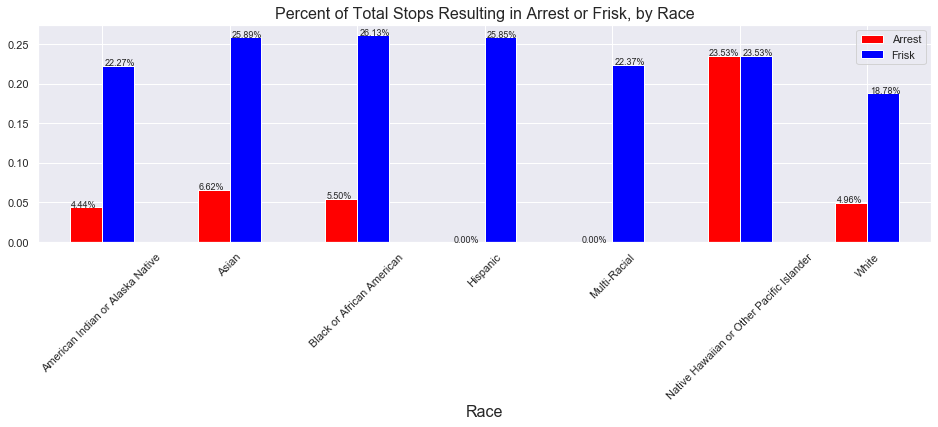

In [61]:
# Plot the data
ax = df4.plot(kind = 'bar', figsize = (16, 4), color = ['red', 'blue'])

# Generate text values above the columns
for i, v in enumerate(df4.percent_arrest):
    ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
for i, v in enumerate(df4.percent_frisk):
    ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )

# Display barchart
plt.xticks(rotation = 45)
plt.title('Percent of Total Stops Resulting in Arrest or Frisk, by Race', fontsize = 16)
plt.xlabel('Race', fontsize = 16)
plt.legend(loc = 'best', labels = ['Arrest', 'Frisk'] )


# Hypothesis Test

Is there a meaningful difference between the proportion of black subjects stopped and the proportion of black residents according to the census data?

$H$o: The census black population percentage is the same as the percentage of black subjects that were stopped. 

$H$a: The census black population percentage is ***not*** the same as the percentage of black subjects that were stopped

Significance Level: *95%* Confidence. <br> $α$ = 0.05

In [62]:
# Create dataframe with census population percentages
df6 = pd.DataFrame(index = ['American Indian / Alaskan Native','Asian','Black','Hispanic',
                           'Multi-Racial','Other','White'], 
                  data = {'census_pct' : [.04,.137,.077,.066,.044,.002,.663,]} )

df6.head()

,census_pct
American Indian / Alaskan Native,0.040
Asian,0.137
Black,0.077
Hispanic,0.066
Multi-Racial,0.044


In [63]:
# Bootstrap sample repeatibility
def bootstrap_replicate_1d(df, func):
    boot_sample = np.random.choice(df, size=len(df))  
    return func(boot_sample) 

# Apply bootstrap replicate function 'n' and return an array
def draw_bs_reps(df, func, size=1):
    boot_rep = np.empty(size) # initialize bs_replicates
    
    for i in range(size):  # generate 'n' number of replicates
        boot_rep[i] = bootstrap_replicate_1d(df, func)
    return boot_rep

# Compare arrest % to Census for Seattle black population of 7.7%
def diff_from_census(df, census_value = .077):
    return np.mean(df) - census_value

In [64]:
# Portion of Black subjects stopped
black_prop = len(df[df.subj_perceived_race == 'Black or African American']) / len(df)
black_prop

0.29769211023732295

In [65]:
# Difference between Census and blacks stopped
diff_obs = diff_from_census(black_prop)
diff_obs

0.22069211023732294

In [66]:
# Simulation where the proportion of stops is equal to Census
race_data_shifted = np.random.binomial(1, .077, size = len(df) )

# Bootstrap replicates
# Test statistic is difference between the proportion of stops & Census data
bs_reps = draw_bs_reps(race_data_shifted, diff_from_census, 10000)
np.mean(bs_reps)

0.0009756866497094729

Text(0, 0.5, 'PDF')

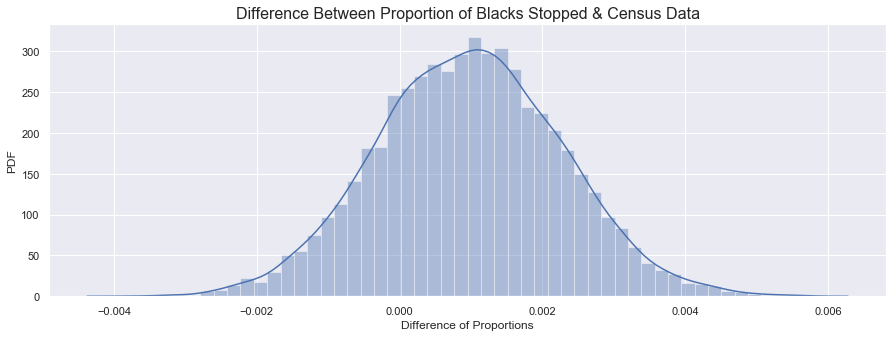

In [67]:
# Plot
plt.figure(figsize=(15, 5))
sns.distplot(bs_reps, kde = True)
plt.title('Difference Between Proportion of Blacks Stopped & Census Data', fontsize = 16)
plt.xlabel('Difference of Proportions', fontsize = 12)
plt.ylabel('PDF')

In [68]:
conf_int = np.percentile(bs_reps, [2.5, 97.5])
print('There is a 95% CI that the difference between the census data & observed data would be between '
      '{:.4f} and {:.4f}. \nThe observed difference was {:.4f}.'.format(conf_int[0], conf_int[1], diff_obs)) 

There is a 95% CI that the difference between the census data & observed data would be between -0.0015 and 0.0035. 
The observed difference was 0.2207.


In [69]:
p_value = np.sum(bs_reps >= diff_obs) / 1000
p_value

0.0

## Result
The hypothesis test makes the assumption that the proportion of Black residents in Seattle is within range of the proportion of Blacks stopped. The difference in proportions is significant enough to yield a p-value of 0 and reject this null hypothesis.